In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
# from fairmlhealth import report, measure, stat_utils
from sklearn.tree import DecisionTreeClassifier
import xgboost 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score, \
                            mean_squared_error, precision_score, recall_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

filePath = "/content/drive/MyDrive/ML_Project_Drought/train_timeseries/train_timeseries.csv"
test_file = "/content/drive/MyDrive/ML_Project_Drought/test_timeseries/test_timeseries.csv"
val_file = "/content/drive/MyDrive/ML_Project_Drought/validation_timeseries/validation_timeseries.csv"


Mounted at /content/drive


In [3]:
# reads the data set from the file
# train_data = pd.read_csv("cleaned_data.csv")
train_data = pd.read_csv(filePath)
test_data = pd.read_csv(test_file)
validation_data = pd.read_csv(val_file)

In [4]:
print(train_data.shape)
# print(test_data.shape)
# print(validation_data.shape)
train_data.head()

(19300680, 21)


,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [5]:
#remove nan values
train_data = train_data.dropna()
test_data = test_data.dropna()
validation_data = validation_data.dropna()

In [7]:
train_data['date'] = pd.to_datetime(train_data['date'])
validation_data['date'] = pd.to_datetime(validation_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [8]:
train_data.set_index('date', inplace=True)
validation_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)


In [10]:
train_new = train_data.copy()
test_new = test_data.copy()
validation_new = validation_data.copy()

In [11]:
df_train = train_new.sample(frac =0.01)
df_test = test_new.sample(frac = 0.05)

In [13]:
scalar = MinMaxScaler()
df_tr_scaled = scalar.fit_transform(df_train) 
df_tt_scaled = scalar.fit_transform(df_test) 


In [16]:
#Fitting XGBoost regressor model
def XGBoost_Regressor(X, y, X_test, y_test):
  model = XGBRegressor()
  model.fit(X, y)

  
  yhat = model.predict(X_test)

  rmse = np.sqrt(mean_squared_error(y_test, yhat))
  mae = mean_absolute_error(y_test, yhat)
  test_y_class = y_test.round()
  pred_y_class = yhat.round()

  fs = f1_score(test_y_class,pred_y_class, labels=[0,1,2,3,4,5,6], average='weighted' )
  acc = accuracy_score(test_y_class,pred_y_class)
  pre = precision_score(test_y_class, pred_y_class, average='weighted')
  rec = recall_score(test_y_class, pred_y_class, average='weighted')
  model_name = 'XGBRegressor'

  print("Results for ", model_name)
  print("Accuracy:",acc)
  print("Precision:",pre)
  print("Recall:",rec)
  print("F1-score:",fs)
  print("MAE:",mae)
  print("rmse:",rmse)

In [17]:
X = df_train.drop(['score'], axis=1, inplace=False)
y = df_train['score']
X_test = df_test.drop(['score'], axis=1, inplace=False)
y_test = df_test.score
XGBoost_Regressor(X, y, X_test, y_test)

[05:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Results for  XGBRegressor
Accuracy: 0.40706012134583563
Precision: 0.7053971130885435
Recall: 0.40706012134583563
F1-score: 0.4712350481974276
MAE: 0.7091099125082501
rmse: 0.8670459758151733


In [18]:
features = df_tr_scaled[:,:-1]
target = df_tr_scaled[:,-1]
features.shape

(27568, 19)

In [19]:
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.47334763, 0.00140428, 0.82639083, 0.51496437, 0.84939482,
          0.80609713, 0.80141586, 0.8634032 , 0.85533294, 0.52223767,
          0.83377699, 0.23695976, 0.26039387, 0.21925134, 0.19230769,
          0.29534606, 0.26559546, 0.22435473, 0.16297895],
         [0.92018822, 0.0020284 , 0.9194856 , 0.82517815, 0.86885246,
          0.94930876, 0.94808495, 0.80741609, 0.93459045, 0.20291869,
          0.85803017, 0.17436662, 0.22647702, 0.00891266, 0.30904184,
          0.18436754, 0.26559546, 0.02514891, 0.32541824]]]), array([0.35378]))

In [20]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42, shuffle=False)

In [21]:
win_length = 25
batch_size = 32
num_features = 20
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [22]:
model = tf.keras.Sequential()
model.add(Bidirectional(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))


In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy','mae','mse'])
model.fit_generator(train_generator, epochs=50, validation_data=test_generator, 
                    shuffle=False, callbacks=[early_stopping])

Epoch 1/50
689/689 [==============================] - 88s 92ms/step - loss: 0.0615 - accuracy: 0.5439 - mae: 0.1954 - mse: 0.0615 - val_loss: 0.0611 - val_accuracy: 0.5261 - val_mae: 0.1987 - val_mse: 0.0611
Epoch 2/50
689/689 [==============================] - 57s 82ms/step - loss: 0.0608 - accuracy: 0.5440 - mae: 0.1950 - mse: 0.0608 - val_loss: 0.0612 - val_accuracy: 0.5261 - val_mae: 0.1999 - val_mse: 0.0612
Epoch 3/50
689/689 [==============================] - 57s 83ms/step - loss: 0.0608 - accuracy: 0.5440 - mae: 0.1951 - mse: 0.0608 - val_loss: 0.0611 - val_accuracy: 0.5261 - val_mae: 0.1992 - val_mse: 0.0611


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 256)        151552    
 l)                                                              
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, None, 256)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                        

In [25]:
model.evaluate_generator(test_generator, verbose=0)

[0.06114445999264717,
 0.5261431932449341,
 0.19916145503520966,
 0.06114445999264717]

In [26]:
predictions = model.predict_generator(test_generator)

In [27]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,0:][win_length:])], axis=1)

In [28]:
rev_trans = scalar.inverse_transform(df_pred)

In [29]:
df_final = df_train[predictions.shape[0]*-1:]

In [30]:
df_final['score_pred'] = rev_trans[:,19]


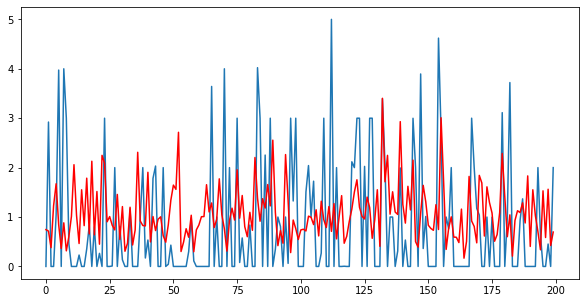

In [31]:
# aa=[x for x in range(500)]
plt.figure(figsize=(10,5))
plt.plot(df_final['score'].values[0:200],  label="actual")
plt.plot(df_final['score_pred'].values[0:200],'r', label="prediction")

plt.show();

In [ ]:
test_multi = df_final['score'].round()
pred_multi = df_final['score_pred'].round()
test_bin = test_multi.map({0:0, 1:1, 2:1, 3:1, 4:1, 5:1})
pred_bin = pred_multi.map({0:0, 1:1, 2:1, 3:1, 4:1, 5:1})


mae = mean_absolute_error(test_bin, pred_bin).round(3)
print("RMSE: ", np.sqrt(MSE(test_bin, pred_bin)))
f1 = f1_score(test_bin,pred_bin).round(3)
print( f"MAE {mae}")
print( f"F1 {f1}")
print(f"Recall {recall_score(test_bin,pred_bin).round(3)}")
print("Precision: ",precision_score(test_bin,pred_bin).round(3))
print("Accuracy", accuracy_score(test_bin,pred_bin).round(3))

RMSE:  0.7574251383641201
MAE 0.574
F1 0.542
Recall 0.86
Precision:  0.395
Accuracy 0.426
